<h1 style="text-align:center;font-size:30px;" > Quora Insincere Questions Classification </h1>

# 1. Introduction

## 1.1. Description

<p>An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.</p>

<p>Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.</p>

<p>In this we will develop models that identify and flag insincere questions.</p><br>

### Problem statement:
Build a model for predicting whether a question asked on Quora is sincere or not.

# 2. Data Overview
<p>Train data consists of 1.3 million rows and 3 features in it.</p>
<p>
-train.csv - the training set
-test.csv - the test set
-sample_submission.csv - A sample submission in the correct format
-enbeddings
</p>
<p>Size of train.csv:  </p>
<p>No. of rows: 1.31M</p>
<p>No. of columns: 3</p>

## Data fields
<p>
1.qid - unique question identifier<br>
2.question_text - Quora question text<br>
3.target - a question labeled "insincere" has a value of 1, otherwise 0<br>
</p>

## Evaluation
<p>As this dataset is highly imbalanced, we will use F1 score as a metric for this dataset.</p>
<p>Metric is F1 Score between the predicted and the observed targets. 
There are just two classes, but the positive class makes just over 6% of the total. 
So the target is highly imbalanced, which is why a metric such as F1 seems appropriate for this kind of problem as it considers both precision and recall of the test to compute the score.</p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import os
import gc
import csv
import re
import string

from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack
from IPython.display import Image
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
from bs4 import BeautifulSoup

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3.1 Reading data and basic stats

In [3]:
train = pd.read_csv("train.csv")
test=pd.read_csv('test.csv')
print("Number of train data points:",train.shape[0])
print("Number of test data points:",test.shape[0])
print("Shape of Train Data:", train.shape)
print("Shape of Test Data:", test.shape)

Number of train data points: 1306122
Number of test data points: 375806
Shape of Train Data: (1306122, 3)
Shape of Test Data: (375806, 2)


In [5]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [7]:
# Checking for null values.
train['question_text'].isnull().sum(), test['question_text'].isnull().sum()

(0, 0)

## 3.1.1 Distribution of data points among output classes

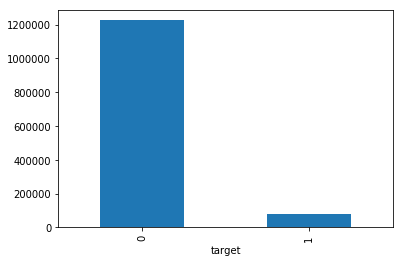

In [8]:
train.groupby("target")['qid'].count().plot.bar()

### Data is highly imbalanced with very few questions marked as insincere.
## 3.1.2 Let's Check Percentage of Sincere and Insincere questions.

In [8]:
print('~> Percentage of Sincere Questions (is_duplicate = 0):\n   {}%'.format(100 - round(train['target'].mean()*100, 2)))
print('\n~> Percentage of Insincere Questions (is_duplicate = 1):\n   {}%'.format(round(train['target'].mean()*100, 2)))

~> Percentage of Sincere Questions (is_duplicate = 0):
   93.81%

~> Percentage of Insincere Questions (is_duplicate = 1):
   6.19%


In [ ]:
sns.boxplot(x="target", y="question_text", data=train)
plt.grid()
plt.show()

## 3.2 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid____ = Frequency of qid
 - ____qlen____ = Length of qid
 - ____n_words____ = Number of words in Question
 - ____numeric_words____ = Number of numeric words in Question
 - ____sp_char_words____ = Number of special characters in Question
 - ____unique_words____ = Number of unique words in Question
 - ____char_words____ = Number of characters in Question

In [4]:
if os.path.isfile('fe_without_preprocessing_train.csv'):
    train = pd.read_csv("fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    train['freq_qid'] = train.groupby('qid')['qid'].transform('count') 
    train['qlen'] = train['question_text'].str.len() 
    train['n_words'] = train['question_text'].apply(lambda row: len(row.split(" ")))
    train['numeric_words'] = train['question_text'].apply(lambda row: sum(c.isdigit() for c in row))
    train['sp_char_words'] = train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
    train['char_words'] = train['question_text'].apply(lambda row: len(str(row)))
    train['unique_words'] = train['question_text'].apply(lambda row: len(set(str(row).split())))
    
    
    train.to_csv("C:/Users/priya/Downloads/quora-insincere-questions-classification/fe_without_preprocessing_train.csv", index=False)
    
train.head()

,qid,question_text,target,freq_qid,qlen,n_words,numeric_words,sp_char_words,char_words,unique_words
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,1,72,13,4,1,72,13
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,1,81,16,0,2,81,15
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,1,67,10,0,2,67,8
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,1,57,9,0,1,57,9
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,1,77,15,0,1,77,15


In [5]:
from datetime import datetime
start = datetime.now()

if os.path.isfile('fe_without_preprocessing_test.csv'):
    test = pd.read_csv("fe_without_preprocessing_test.csv",encoding='latin-1')
else:
    test['freq_qid'] = test.groupby('qid')['qid'].transform('count') 
    test['qlen'] = test['question_text'].str.len() 
    test['n_words'] = test['question_text'].apply(lambda row: len(row.split(" ")))
    test['numeric_words'] = test['question_text'].apply(lambda row: sum(c.isdigit() for c in row))
    test['sp_char_words'] = test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
    test['char_words'] = test['question_text'].apply(lambda row: len(str(row)))
    test['unique_words'] = test['question_text'].apply(lambda row: len(set(str(row).split())))
    
    test.to_csv("C:/Users/priya/Downloads/quora-insincere-questions-classification/fe_without_preprocessing_test.csv", index=False)
    
#test.head()
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.666640


### 3.2.1 Analysis of some of the extracted features

In [11]:
print ("Minimum length of the questions: " , min(train['n_words']))

print ("Maximum length of the questions: " , max(train['n_words']))

print ("Number of Questions with minimum length:", train[train['n_words']== 1].shape[0])

Minimum length of the questions:  1
Maximum length of the questions:  122
Number of Questions with minimum length: 3


#### 3.2.1.1 Feature: n_words

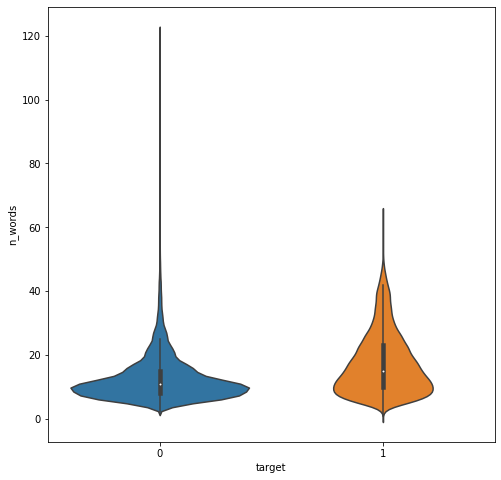

In [12]:
plt.figure(figsize=(8, 8))
sns.violinplot(x = 'target', y = 'n_words', data = train[0:])
plt.show()

#### 3.2.1.1 Feature: numeric_words

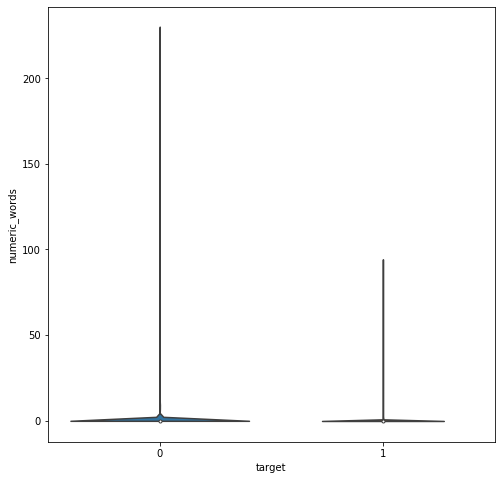

In [13]:
plt.figure(figsize=(8, 8))
sns.violinplot(x = 'target', y = 'numeric_words', data = train[0:])
plt.show()

#### 3.2.1.1 Feature: sp_char_words

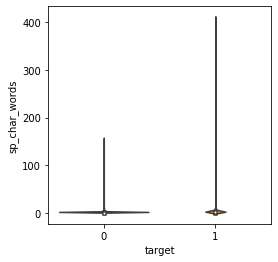

In [14]:
plt.figure(figsize=(4, 4))
sns.violinplot(x = 'target', y = 'sp_char_words', data = train[0:])
plt.show()

#### 3.2.1.1 Feature: char_words

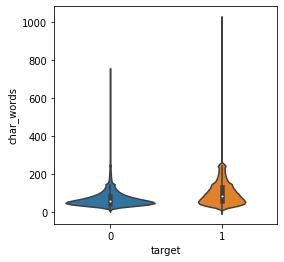

In [15]:
plt.figure(figsize=(4, 4))
sns.violinplot(x = 'target', y = 'char_words', data = train[0:])
plt.show()

#### 3.2.1.1 Feature: unique_words

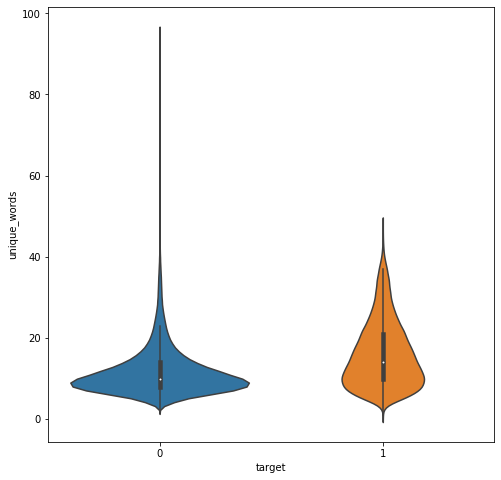

In [16]:
plt.figure(figsize=(8, 8))
sns.violinplot(x = 'target', y = 'unique_words', data = train[0:])
plt.show()

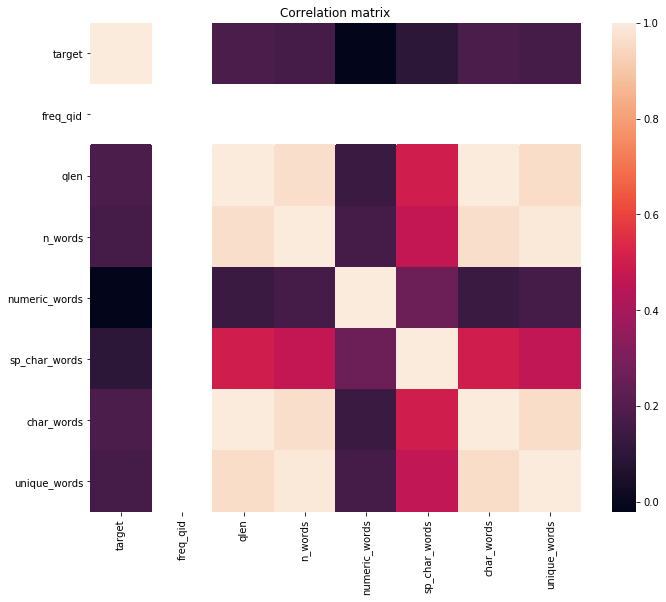

In [17]:
#Code Reference: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
 
corr = train.corr()

# Draw the heatmap
sns.heatmap(corr, ax=ax)

plt.title("Correlation matrix")
plt.show()

In [18]:
# printing out a random sample of questions labeled insincere
import random

index = random.sample(train.index[train.target == 1].tolist(), 5)
for i in index:
    print(train.iloc[i, 1])

Do you still "blow" your brother?
If Islam is all encompassing including politics, economics, morality and religious affairs why do people blame tensions and wars in their countries on politics and not on Islam?
Have you ever ate/cleaned up your own creampie after sex? What was your first experience like? What has been your favorite position to do this? Do you have any other "cumplay" ideas for a straight man with a cum fetish besides being snowballed?
When a transgender takes a big shit in the womenâs restroom, do gas masks drop down from the ceiling?
Why do Muslims of Pakistan eat pork even though its haram in Islam?


In [19]:
qids = train.sort_values('sp_char_words', ascending=False)['qid'].head(20).values
for id in qids:
    row = train[train['qid'].values == id]
    if row['target'].values[0] == 1: 
        color = '\033[31m'
    else:
        color = '\033[0m'
    print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

## 3.3 Preprocessing of Text


- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [11]:
#Code Reference: 
#https://github.com/ronakvijay/Quora_Insincere_Questions/blob/master/QIQC_LR.ipynb
#https://www.kaggle.com/canming/ensemble-mean-iii-64-36
#https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

## Replacing puctuations

In [6]:
puncts=[',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

In [7]:
def clean_punct(x):
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '{}' .format(punct))
    return x

## Cleaning Numbers

In [8]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

## Correcting mispelled words

In [9]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}


In [10]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)


## Removing Contractions

In [11]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [12]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

In [13]:
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

## Removing Stopwords

In [14]:
stopword_list = nltk.corpus.stopwords.words('english')
def remove_stopwords(text, is_lower_case=True):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [15]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

## Stemming

In [16]:
from nltk.stem import  SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
def stem_text(text):
    tokenizer = ToktokTokenizer()
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

## Lemmatization

In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemma_text(text):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [18]:
def clean_sentence(x):
    x = x.lower()
    x = clean_punct(x)
    x = clean_numbers(x)
    x = replace_typical_misspell(x)
    x = remove_stopwords(x)
    x = replace_contractions(x)
    #x = preprocess(x)
    x = stem_text(x)
    x = lemma_text(x)
    x = x.replace("'","")
    return x

In [19]:
# preprocessing given train and test data
train['preprocessed_question_text'] = train['question_text'].apply(lambda x: clean_sentence(x))
test['preprocessed_question_text'] = test['question_text'].apply(lambda x: clean_sentence(x))

# Analysis of Extracted Features

Creating Word Cloud of Sincere and Insincere Question pairs, so we can observe the most frequent occuring words

In [35]:
def cloud(text, title, size = (10,7)):
    # Processing Text
    words_list = text.unique().tolist()
    words = ' '.join(words_list)
    
    wordcloud = WordCloud(width=800, height=400,
                          collocations=False
                         ).generate(words)
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=25,color='w')
    plt.tight_layout(pad=0)
    plt.show()

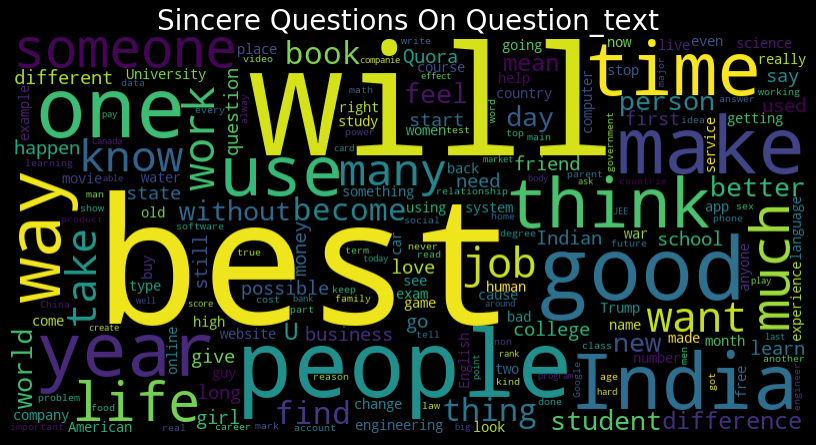

In [36]:
cloud(train[train['target']==0]['question_text'], 'Sincere Questions On Question_text')

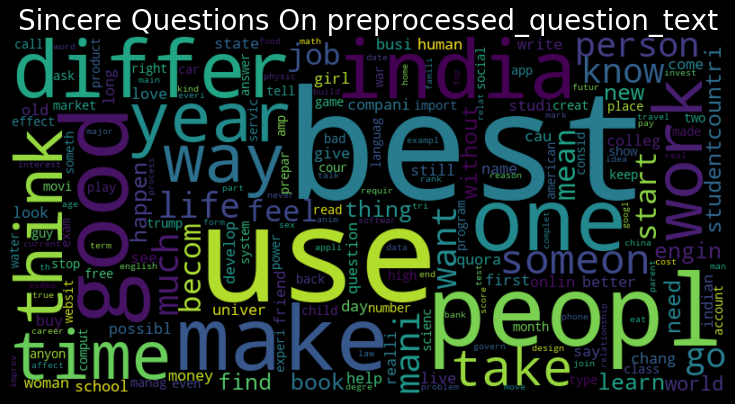

In [37]:
cloud(train[train['target']==0]['preprocessed_question_text'], 'Sincere Questions On preprocessed_question_text')

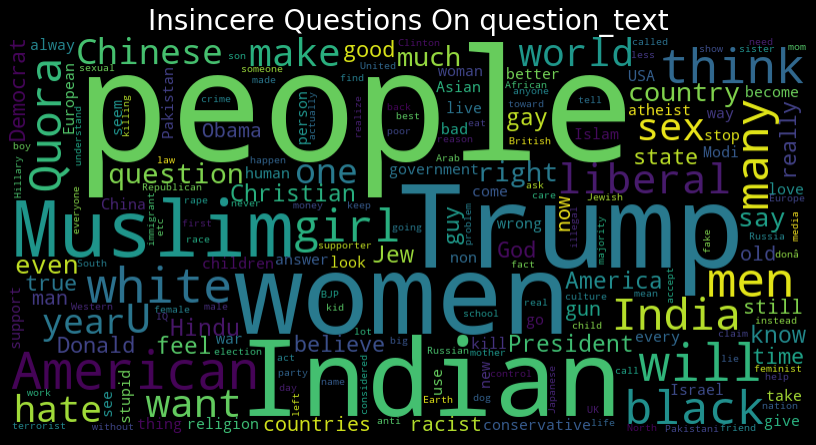

In [38]:
cloud(train[train['target']==1]['question_text'], 'Insincere Questions On question_text')

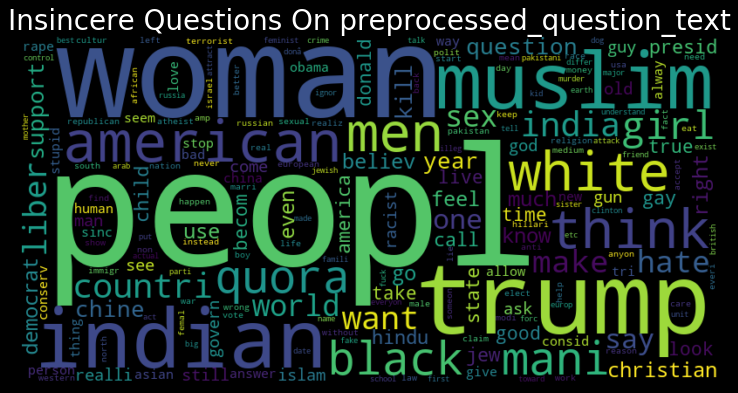

In [39]:
cloud(train[train['target']==1]['preprocessed_question_text'], 'Insincere Questions On preprocessed_question_text')

# 3.4 Function to find threshold and best f-score

In [20]:
# small function to find threshold and find best f score - Eval metric of competition
def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return tmp[2]

# 3.5 Modelling

In [21]:
warnings.filterwarnings("ignore")
import copy
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import f1_score

## Function that splits X_train and y_train into train and validation data and trains the model as per the passed parameter

### We'll use this function to apply machine learning classification model like Logistic Regression, Naive Bayes, LightGBM

In [22]:
def model_train_cv(x_train,y_train,nfold,model_obj):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):

        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]

        clf = copy.deepcopy(model_obj)
        clf.fit(x_train_fold, y_train_fold)
        valid_preds_fold = clf.predict_proba(x_val_fold)[:,1]

        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

## 3.5.1 Bag of Words

In [29]:
SEED = 1029

In [30]:
tr_score = []
ts_score = []

In [31]:
cnt_vectorizer = CountVectorizer(dtype=np.float32,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),min_df=3)

# Fitting count vectorizer to both training and test sets (semi-supervised learning)
cnt_vectorizer.fit(list(train.preprocessed_question_text.values) + list(test.preprocessed_question_text.values))
X_train =  cnt_vectorizer.transform(train.preprocessed_question_text.values) 
X_test = cnt_vectorizer.transform(test.preprocessed_question_text.values)
y_train = train.target.values

print("Number of data points in train data :",X_train.shape, y_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (1306122, 769804) (1306122,)
Number of data points in test data : (375806, 769804)


### 3.5.1.1 Logistic Regression

In [32]:
# Fitting a simple Logistic Regression on CountVectorizer Model
train_oof_preds = model_train_cv(X_train,y_train,5,LogisticRegression(C=1.0))
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " %f1 )

ts_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.85it/s]

best threshold is 0.2000 with F1 score: 0.6062
F1 Score: 0.606 


### 3.5.1.2 Naive Bayes

In [33]:
train_oof_preds = model_train_cv(X_train,y_train,5,MultinomialNB())

f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
ts_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.83it/s]

best threshold is 0.5000 with F1 score: 0.5411
F1 Score: 0.541 


### 3.5.1.3 Light GBM

### Function for Light GBM

In [23]:
import lightgbm as lgb

def lgb_model_train_cv(x_train,y_train,nfold,lgb):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):
        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]
        d_train = lgb.Dataset(x_train_fold, label=y_train_fold)
        d_val = lgb.Dataset(x_val_fold, label=y_val_fold)
        params = {}
        params['learning_rate'] = 0.01
        params['boosting_type'] = 'gbdt'
        params['objective'] = 'binary'
        params['metric'] = 'binary_logloss'
        params['sub_feature'] = 0.5
        params['num_leaves'] = 10
        params['min_data'] = 50
        params['max_depth'] = 10
        
        clf = lgb.train(params, d_train, num_boost_round = 100,valid_sets=(d_val), early_stopping_rounds=10,verbose_eval=10)
        valid_preds_fold = clf.predict(x_val_fold)
        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

In [35]:
train_oof_preds = lgb_model_train_cv(X_train,y_train,5,lgb)

f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
ts_score.append(f1)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.223457
[20]	valid_0's binary_logloss: 0.216853
[30]	valid_0's binary_logloss: 0.211696
[40]	valid_0's binary_logloss: 0.207606
[50]	valid_0's binary_logloss: 0.20408
[60]	valid_0's binary_logloss: 0.201095
[70]	valid_0's binary_logloss: 0.19846
[80]	valid_0's binary_logloss: 0.196214
[90]	valid_0's binary_logloss: 0.19416
[100]	valid_0's binary_logloss: 0.192326
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.192326
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.223059
[20]	valid_0's binary_logloss: 0.217203
[30]	valid_0's binary_logloss: 0.211795
[40]	valid_0's binary_logloss: 0.207545
[50]	valid_0's binary_logloss: 0.203912
[60]	valid_0's binary_logloss: 0.20089
[70]	valid_0's binary_logloss: 0.19827
[80]	valid_0's binary_logloss: 0.195935
[90]	valid_0's binary_logloss: 0.193886
[100]	valid_0's binary_logloss:

100%|██████████| 41/41 [00:13<00:00,  2.95it/s]

best threshold is 0.1100 with F1 score: 0.4481
F1 Score: 0.448 


## 3.5.2 TFIDF Vectorizer

In [36]:
tfv = TfidfVectorizer(dtype=np.float32, min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(train.preprocessed_question_text.values) + list(test.preprocessed_question_text.values))
X_train =  tfv.transform(train.preprocessed_question_text.values) 
X_test_tfv = tfv.transform(test.preprocessed_question_text.values)
y_train = train.target.values

print("Number of data points in train data :",X_train.shape, y_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (1306122, 693159) (1306122,)
Number of data points in test data : (375806, 769804)


### 3.5.2.1 Logistic Regression

In [37]:
# Fitting a simple Logistic Regression on CountVectorizer Model
train_oof_preds = model_train_cv(X_train,y_train,5,LogisticRegression(C=1.0))
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " %f1 )

ts_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.82it/s]

best threshold is 0.2100 with F1 score: 0.5941
F1 Score: 0.594 


### 3.5.2.2 Naive Bayes

In [38]:
train_oof_preds = model_train_cv(X_train,y_train,5,MultinomialNB())

f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
ts_score.append(f1)

100%|██████████| 41/41 [00:13<00:00,  2.94it/s]

best threshold is 0.1000 with F1 score: 0.5030
F1 Score: 0.503 


### 3.5.1.3 Light GBM

In [39]:
train_oof_preds = lgb_model_train_cv(X_train,y_train,5,lgb)

f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
ts_score.append(f1)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.223323
[20]	valid_0's binary_logloss: 0.216852
[30]	valid_0's binary_logloss: 0.211939
[40]	valid_0's binary_logloss: 0.207575
[50]	valid_0's binary_logloss: 0.204133
[60]	valid_0's binary_logloss: 0.200985
[70]	valid_0's binary_logloss: 0.198404
[80]	valid_0's binary_logloss: 0.196103
[90]	valid_0's binary_logloss: 0.194047
[100]	valid_0's binary_logloss: 0.192222
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.192222
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.223393
[20]	valid_0's binary_logloss: 0.216843
[30]	valid_0's binary_logloss: 0.211598
[40]	valid_0's binary_logloss: 0.207503
[50]	valid_0's binary_logloss: 0.203877
[60]	valid_0's binary_logloss: 0.200798
[70]	valid_0's binary_logloss: 0.198221
[80]	valid_0's binary_logloss: 0.195918
[90]	valid_0's binary_logloss: 0.193921
[100]	valid_0's binary_log

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]

best threshold is 0.1200 with F1 score: 0.4423
F1 Score: 0.442 


## 3.5.3 Hashing Vectorizer

In [40]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(dtype=np.float32,
            strip_accents='unicode', analyzer='word',
            ngram_range=(1, 3),n_features=2**10)
# Fitting Hash Vectorizer to both training and test sets (semi-supervised learning)
hv.fit(list(train.preprocessed_question_text.values) + list(test.preprocessed_question_text.values))
X_train =  hv.transform(train.preprocessed_question_text.values) 
X_test_tfv = hv.transform(test.preprocessed_question_text.values)
y_train = train.target.values

print("Number of data points in train data :",X_train.shape, y_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (1306122, 1024) (1306122,)
Number of data points in test data : (375806, 769804)


### 3.5.3.1 Logistic Regression

In [41]:
# Fitting a simple Logistic Regression on CountVectorizer Model
train_oof_preds = model_train_cv(X_train,y_train,5,LogisticRegression(C=1.0))
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " %f1 )

ts_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.87it/s]

best threshold is 0.1500 with F1 score: 0.3491
F1 Score: 0.349 


### 3.5.3.3 Light GBM

In [42]:
train_oof_preds = lgb_model_train_cv(X_train,y_train,5,lgb)

f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
ts_score.append(f1)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.226722
[20]	valid_0's binary_logloss: 0.222704
[30]	valid_0's binary_logloss: 0.219474
[40]	valid_0's binary_logloss: 0.216847
[50]	valid_0's binary_logloss: 0.214056
[60]	valid_0's binary_logloss: 0.211864
[70]	valid_0's binary_logloss: 0.209935
[80]	valid_0's binary_logloss: 0.208253
[90]	valid_0's binary_logloss: 0.206681
[100]	valid_0's binary_logloss: 0.205351
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.205351
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.226731
[20]	valid_0's binary_logloss: 0.222754
[30]	valid_0's binary_logloss: 0.219543
[40]	valid_0's binary_logloss: 0.216893
[50]	valid_0's binary_logloss: 0.21414
[60]	valid_0's binary_logloss: 0.21194
[70]	valid_0's binary_logloss: 0.210011
[80]	valid_0's binary_logloss: 0.208312
[90]	valid_0's binary_logloss: 0.206746
[100]	valid_0's binary_loglo

  0%|          | 0/41 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.205193
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.205193


100%|██████████| 41/41 [00:14<00:00,  2.92it/s]

best threshold is 0.1100 with F1 score: 0.3469
F1 Score: 0.347 


## 3.5.4 Word2vec Embeddings

In [43]:
def load_glove_index():
    EMBEDDING_FILE = 'glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    f = open(EMBEDDING_FILE,encoding="utf-8")
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in f)
    return embeddings_index

embeddings_index = load_glove_index()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [44]:
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = stopwords.words('english')
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [45]:
# create sentence vectors using the above function for training and validation set
xtrain = [sent2vec(x) for x in tqdm(train.preprocessed_question_text.values)]
xtest_glove = [sent2vec(x) for x in tqdm(test.preprocessed_question_text.values)]

100%|██████████| 375806/375806 [01:05<00:00, 5757.06it/s]


In [46]:
X_train = np.array(xtrain)
# xvalid_glove = np.array(xtest_glove)
y_train = train.target.values

In [24]:
y_train = train.target.values

### 3.5.4.1 Logistic Regression

In [47]:
# Fitting a simple Logistic Regression on CountVectorizer Model
train_oof_preds = model_train_cv(X_train,y_train,5,LogisticRegression(C=1.0))
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " %f1 )

ts_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.88it/s]

best threshold is 0.2300 with F1 score: 0.5191
F1 Score: 0.519 


### 3.5.4.3 Light GBM

In [48]:
train_oof_preds = lgb_model_train_cv(X_train,y_train,5,lgb)

f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
ts_score.append(f1)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.225186
[20]	valid_0's binary_logloss: 0.219431
[30]	valid_0's binary_logloss: 0.214441
[40]	valid_0's binary_logloss: 0.209899
[50]	valid_0's binary_logloss: 0.206006
[60]	valid_0's binary_logloss: 0.202491
[70]	valid_0's binary_logloss: 0.199455
[80]	valid_0's binary_logloss: 0.196466
[90]	valid_0's binary_logloss: 0.193907
[100]	valid_0's binary_logloss: 0.191445
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.191445
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.225241
[20]	valid_0's binary_logloss: 0.219456
[30]	valid_0's binary_logloss: 0.214419
[40]	valid_0's binary_logloss: 0.209854
[50]	valid_0's binary_logloss: 0.205914
[60]	valid_0's binary_logloss: 0.202389
[70]	valid_0's binary_logloss: 0.199331
[80]	valid_0's binary_logloss: 0.196344
[90]	valid_0's binary_logloss: 0.193777
[100]	valid_0's binary_log

100%|██████████| 41/41 [00:13<00:00,  2.97it/s]

best threshold is 0.1100 with F1 score: 0.4302
F1 Score: 0.430 


# Comparing performance for all the models

In [49]:
from prettytable import PrettyTable
    
x = PrettyTable()
vect = (["CountVectorizer"] * 3) + (["TFIDFVectorizer"] * 3) + (["HashingVectorizer"] * 2) + (["Word2vec"] * 2)
model = (["Logistic Regression", "Naive Bayes", "LightGBM"] * 2) + (["Logistic Regression", "LightGBM"] * 2)
#x.field_names = ["Model", "Test F1-Score"]
x.add_column("Model", model)
x.add_column("Vectorizer", vect)
x.add_column("Test F1-Score", ts_score)

In [50]:
print(x)

+---------------------+-------------------+---------------------+
|        Model        |     Vectorizer    |    Test F1-Score    |
+---------------------+-------------------+---------------------+
| Logistic Regression |  CountVectorizer  |  0.6061869265414231 |
|     Naive Bayes     |  CountVectorizer  |  0.5411124898212416 |
|       LightGBM      |  CountVectorizer  | 0.44805759949363083 |
| Logistic Regression |  TFIDFVectorizer  |  0.5940808706791779 |
|     Naive Bayes     |  TFIDFVectorizer  |  0.5029684543565248 |
|       LightGBM      |  TFIDFVectorizer  | 0.44225094843332863 |
| Logistic Regression | HashingVectorizer |  0.3491367081425039 |
|       LightGBM      | HashingVectorizer |  0.3469309621513192 |
| Logistic Regression |      Word2vec     |  0.5191204693754455 |
|       LightGBM      |      Word2vec     |  0.4302154845215734 |
+---------------------+-------------------+---------------------+


# DEEP LEARNING MODELS

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from unidecode import unidecode

from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA

Using TensorFlow backend.


## Basic Parameters

In [26]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

## Embedding Functions

In [27]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    
    f = open(EMBEDDING_FILE,encoding="utf-8")
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in f)
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        #ALLmight
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix 

In [28]:
def load_fasttext(word_index):    
    EMBEDDING_FILE = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    
    f = open(EMBEDDING_FILE,encoding="utf-8")
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in f if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [29]:
def load_para(word_index):
    EMBEDDING_FILE = 'paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [30]:
train_X = train['preprocessed_question_text'].values
test_X = test['preprocessed_question_text'].values

## Sequence Creation
## Tokenizer

In [31]:
from keras.preprocessing.text import Tokenizer
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X)+list(test_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [32]:
word_index = tokenizer.word_index

## Pad Sequence

In [33]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Load Embeddings

In [34]:
glove_embeddings = load_glove(word_index)    
paragram_embeddings = load_para(word_index)
embedding_matrix = np.mean([glove_embeddings, paragram_embeddings], axis=0) 

In [35]:
np.shape(embedding_matrix)

(120000, 300)

In [36]:
dl_score = []

In [37]:
import tensorflow as tf
print(tf.test.is_gpu_available())

True


## Models we are trying:
1. TextCNN
2. BiLSTM
3. Attention

In [38]:
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

In [40]:
def dl_model_train_cv(x_train,y_train,nfold,model_obj):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):
        print('Fold {}'.format(i + 1))
        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]

        clf = copy.deepcopy(model_obj)
        clf.fit(x_train_fold, y_train_fold, batch_size=512, epochs=5, validation_data=(x_val_fold, y_val_fold))
        
        valid_preds_fold = clf.predict(x_val_fold)[:,0]

        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

## TextCNN

In [41]:
filter_sizes = [1,2,3,5]
num_filters = 36

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=False)(inp)
x = Reshape((maxlen, embed_size, 1))(x)

maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                  kernel_initializer='he_normal', activation='relu')(x)
    maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

z = Concatenate(axis=1)(maxpool_pool)   
z = Flatten()(z)
z = Dropout(0.1)(z)

outp = Dense(1, activation="sigmoid")(z)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
train_oof_preds = dl_model_train_cv(train_X,y_train,5,model)

Fold 1
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 58s 56us/step - loss: 0.1345 - acc: 0.9486 - val_loss: 0.1219 - val_acc: 0.9522
Epoch 2/5
1044897/1044897 [==============================] - 54s 52us/step - loss: 0.1195 - acc: 0.9535 - val_loss: 0.1194 - val_acc: 0.9532
Epoch 3/5
1044897/1044897 [==============================] - 54s 52us/step - loss: 0.1137 - acc: 0.9557 - val_loss: 0.1186 - val_acc: 0.9538
Epoch 4/5
1044897/1044897 [==============================] - 54s 52us/step - loss: 0.1088 - acc: 0.9576 - val_loss: 0.1189 - val_acc: 0.9535
Epoch 5/5
1044897/1044897 [==============================] - 54s 52us/step - loss: 0.1045 - acc: 0.9594 - val_loss: 0.1207 - val_acc: 0.9535
Fold 2
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 55s 53us/step - loss: 0.1347 - acc: 0.9486 - val_loss: 0.1217 - val_acc: 0.9530
Epoch 2/5
1044897/1044897 [=======

In [43]:
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
dl_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.87it/s]

best threshold is 0.2400 with F1 score: 0.6101
F1 Score: 0.610 


## BiLSTM

In [44]:
def model_lstm_du(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=False)(inp)
    '''
    Here 64 is the size(dim) of the hidden state vector as well as the output vector. Keeping return_sequence we want the output for the entire sequence. So what is the dimension of output for this layer?
        64*70(maxlen)*2(bidirection concat)
    CuDNNLSTM is fast implementation of LSTM layer in Keras which only runs on GPU
    '''
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [45]:
model = model_lstm_du(embedding_matrix)

In [46]:
train_oof_preds = dl_model_train_cv(train_X,y_train,5,model)

Fold 1
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 45s 43us/step - loss: 0.1298 - acc: 0.9503 - val_loss: 0.1222 - val_acc: 0.9518
Epoch 2/5
1044897/1044897 [==============================] - 44s 42us/step - loss: 0.1124 - acc: 0.9559 - val_loss: 0.1138 - val_acc: 0.9552
Epoch 3/5
1044897/1044897 [==============================] - 44s 42us/step - loss: 0.1052 - acc: 0.9583 - val_loss: 0.1126 - val_acc: 0.9552
Epoch 4/5
1044897/1044897 [==============================] - 44s 42us/step - loss: 0.0985 - acc: 0.9608 - val_loss: 0.1146 - val_acc: 0.9551
Epoch 5/5
1044897/1044897 [==============================] - 44s 42us/step - loss: 0.0918 - acc: 0.9634 - val_loss: 0.1191 - val_acc: 0.9543
Fold 2
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 45s 43us/step - loss: 0.1313 - acc: 0.9499 - val_loss: 0.1166 - val_acc: 0.9546
Epoch 2/5
1044897/1044897 [=======

In [47]:
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
dl_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.85it/s]

best threshold is 0.2900 with F1 score: 0.6272
F1 Score: 0.627 


## Attention

In [48]:
def attention_model_train_cv(x_train,y_train,nfold,model_obj):
    splits = list(StratifiedKFold(n_splits=nfold, shuffle=True, random_state=SEED).split(x_train, y_train))
    x_train = x_train
    y_train = np.array(y_train)
    # matrix for the out-of-fold predictions
    train_oof_preds = np.zeros((x_train.shape[0]))
    for i, (train_idx, valid_idx) in enumerate(splits):
        print('Fold {}'.format(i + 1))
        x_train_fold = x_train[train_idx.astype(int)]
        y_train_fold = y_train[train_idx.astype(int)]
        x_val_fold = x_train[valid_idx.astype(int)]
        y_val_fold = y_train[valid_idx.astype(int)]
        # Changed it here a little bit since the custom attention layer is not getting deepcopy
        clf = model_obj
        clf.load_weights('model.h5')
        clf.fit(x_train_fold, y_train_fold, batch_size=512, epochs=5, validation_data=(x_val_fold, y_val_fold))
        
        valid_preds_fold = clf.predict(x_val_fold)[:,0]

        # storing OOF predictions
        train_oof_preds[valid_idx] = valid_preds_fold
    return train_oof_preds

In [49]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
model = model_lstm_atten(embedding_matrix)
# Changed it here a little bit since the custom attention layer is not getting deepcopy
model.save_weights('model.h5')

In [51]:
train_oof_preds = attention_model_train_cv(train_X,y_train,5,model)

Fold 1
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 118s 113us/step - loss: 0.1299 - acc: 0.9499 - val_loss: 0.1171 - val_acc: 0.9536
Epoch 2/5
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.1116 - acc: 0.9557 - val_loss: 0.1131 - val_acc: 0.9553
Epoch 3/5
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.1036 - acc: 0.9588 - val_loss: 0.1122 - val_acc: 0.9552
Epoch 4/5
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.0952 - acc: 0.9617 - val_loss: 0.1122 - val_acc: 0.9565
Epoch 5/5
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.0857 - acc: 0.9655 - val_loss: 0.1180 - val_acc: 0.9548
Fold 2
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 115s 110us/step - loss: 0.1296 - acc: 0.9497 - val_loss: 0.1186 - val_acc: 0.9534
Epoch 2/5
1044897/1044

In [52]:
f1 = bestThresshold(y_train,train_oof_preds)
print ("F1 Score: %0.3f " % f1)
dl_score.append(f1)

100%|██████████| 41/41 [00:14<00:00,  2.88it/s]

best threshold is 0.3700 with F1 score: 0.6305
F1 Score: 0.630 


# Comparing performance for all the models

In [55]:
from prettytable import PrettyTable
    
x = PrettyTable()
vect = (["CountVectorizer"] * 3) + (["TFIDFVectorizer"] * 3) + (["HashingVectorizer"] * 2) + (["Word2vec"] * 2)
model = (["Logistic Regression", "Naive Bayes", "LightGBM"] * 2) + (["Logistic Regression", "LightGBM"] * 2)
#x.field_names = ["Model", "Test F1-Score"]
x.add_column("Model", model)
x.add_column("Vectorizer", vect)
x.add_column("Test F1-Score", ts_score)

In [56]:
y = PrettyTable()

model = ["TextCNN", "BiLSTM", "Attention"]
#model = ["TextCNN"]

y.add_column("Model", model)
y.add_column("Test F1-Score", dl_score)

In [57]:
print("*" * 20, "Conventional Methods", "*" * 20)
print(x)
print("\n")
print("*" * 20, "Deep Learning Methods", "*" * 20)
print(y)

******************** Conventional Methods ********************
+---------------------+-------------------+---------------------+
|        Model        |     Vectorizer    |    Test F1-Score    |
+---------------------+-------------------+---------------------+
| Logistic Regression |  CountVectorizer  |  0.6061869265414231 |
|     Naive Bayes     |  CountVectorizer  |  0.5411124898212416 |
|       LightGBM      |  CountVectorizer  | 0.44805759949363083 |
| Logistic Regression |  TFIDFVectorizer  |  0.5940808706791779 |
|     Naive Bayes     |  TFIDFVectorizer  |  0.5029684543565248 |
|       LightGBM      |  TFIDFVectorizer  | 0.44225094843332863 |
| Logistic Regression | HashingVectorizer |  0.3491367081425039 |
|       LightGBM      | HashingVectorizer |  0.3469309621513192 |
| Logistic Regression |      Word2vec     |  0.5191204693754455 |
|       LightGBM      |      Word2vec     |  0.4302154845215734 |
+---------------------+-------------------+---------------------+


***********